<a href="https://colab.research.google.com/github/iwatake2222/pico-work/blob/master/pj_tflmicro_mnist/tflmicro_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create models for TensorFlow Lite for Microcontrollers
- Create the original model using Keras (conv_mnist.h5)
- Convert the model into TensorFlow Lite
  - Without quantization (conv_mnist.tflite)
  - With quantization (conv_mnist_quant.tflite)
- Convert tflite model into C code using xxd

## Create the original model using Keras (conv_mnist.h5)
Simple MNIST model

In [23]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np

print(tf.__version__)

# MNISTの学習用データ、テストデータをロードする
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 学習データの前処理
# X: 6000x28x28x1のTensorに変換し、値を-1.0～1.0に正規化
# Y: one-hot化(6000x1 -> 6000x10)   -> no need when using SparseCategoricalCrossentropy()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_train = x_train / 128. - 1.
x_test = x_test / 128. - 1.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)

# 学習状態把握用のTensorBoard設定
tsb = tf.keras.callbacks.TensorBoard(log_dir="./logs")

# Convolutionモデルの作成
input = tf.keras.layers.Input(shape=(28,28,1), name="input_image")
conv1 = tf.keras.layers.Conv2D(
  filters=8,
  kernel_size=(3,3),
  strides=(1,1),
  padding="same",
  activation="relu"
)(input)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = tf.keras.layers.Conv2D(
  filters=4,
  kernel_size=(3,3),
  strides=(1,1),
  padding="same",
  activation="relu"
)(pool1)
dropout1 = tf.keras.layers.Dropout(0.2)(conv2)
flatten1 = tf.keras.layers.Flatten()(dropout1)
output = tf.keras.layers.Dense(units=10, activation="softmax", name="output_scores")(flatten1)
model = tf.keras.models.Model(inputs=[input], outputs=[output], name="ConvMnist")
model.summary()

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Convolutionモデルの学習
model.fit(
  x_train,
  y_train,
  batch_size=32,
  epochs=20,
  validation_split=0.2,
  callbacks=[tsb],
)

# 学習したモデルを使用して、テスト用データで評価する
model.evaluate(x_test,  y_test, verbose=2)

# 学習済みモデルをファイル(h5)に保存する
model.save("conv_mnist.h5")

2.4.1
Model: "ConvMnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 4)         292       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
output_scores (Dense)        (None, 10)            

### Test the model

--2021-02-14 16:54:53--  https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A
Resolving drive.google.com (drive.google.com)... 74.125.142.102, 74.125.142.113, 74.125.142.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4qub1roodu7jv7isu3jjqag0iu96gcuh/1613321625000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download [following]
--2021-02-14 16:54:53--  https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4qub1roodu7jv7isu3jjqag0iu96gcuh/1613321625000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download
Resolving doc-0c-7s-docs.googleusercontent.com (doc-0c-7s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-7s-docs.googleusercontent.com (doc-0c

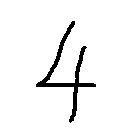

predicted number is 4 [0.97]


In [24]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Read input image
!wget -O 4.jpg  "https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A" 
img_org = cv2.imread("4.jpg")
cv2_imshow(img_org)

# Pre process
## グレースケール化、リサイズ、白黒判定、価範囲を0～255 -> -1.0～1.0
img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))
img = 255 - img
img = img / 128. - 1.
img = img.astype(np.float32)
input_tensor = img.reshape(1, img.shape[0], img.shape[1], 1)

# Load model
loaded_model = tf.keras.models.load_model("conv_mnist.h5")

# Inference
scores = loaded_model.predict(input_tensor)

result = np.argmax(scores[0])
print("predicted number is {} [{:.2f}]".format(result, scores[0][result]))

## Convert the model into TensorFlow Lite without quantization (conv_mnist.tflite)

In [25]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# Convert
loaded_model = tf.keras.models.load_model("conv_mnist.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

tflite_model = converter.convert()
open("conv_mnist.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpojf78kbl/assets


INFO:tensorflow:Assets written to: /tmp/tmpojf78kbl/assets


35396

### Test the model

--2021-02-14 16:55:15--  https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A
Resolving drive.google.com (drive.google.com)... 74.125.142.102, 74.125.142.113, 74.125.142.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bu9bs8o00f7iqhc6ai42cusdc7tjthgd/1613321700000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download [following]
--2021-02-14 16:55:15--  https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bu9bs8o00f7iqhc6ai42cusdc7tjthgd/1613321700000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download
Resolving doc-0c-7s-docs.googleusercontent.com (doc-0c-7s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-7s-docs.googleusercontent.com (doc-0c

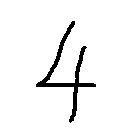

predicted number is 4 [0.97]


In [26]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Read input image
!wget -O 4.jpg  "https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A" 
img = cv2.imread("4.jpg")
cv2_imshow(img)

# Pre process
## グレースケール化、リサイズ、白黒判定、価範囲を0～255 -> -1.0～1.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))
img = 255 - img
img = img / 128. - 1.
img = img.astype(np.float32)
input_tensor = img.reshape(1, img.shape[0], img.shape[1], 1)
input_tensor = tf.convert_to_tensor(input_tensor)

# Load model
interpreter = tf.lite.Interpreter(model_path="conv_mnist.tflite")
# interpreter = tf.lite.Interpreter(model_path="conv_mnist_from_pb.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# set input tensor
interpreter.set_tensor(input_details[0]['index'], input_tensor)

# Inference
interpreter.invoke()

scores = interpreter.get_tensor(output_details[0]['index'])
result = np.argmax(scores[0])
print("predicted number is {} [{:.2f}]".format(result, scores[0][result]))

## Convert the model into TensorFlow Lite with quantization (conv_mnist_quant.tflite)


In [27]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np

print(tf.__version__)

## Prepara dataset generator for calibration
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 128.0 - 1
x_train = x_train.astype(np.float32)
num_calibration_images = 100
calibration_indexes   = np.random.choice(x_train.shape[0], num_calibration_images, replace=False)
def representative_dataset_gen():
  for i in range(num_calibration_images):
    yield [x_train[calibration_indexes[i: i + 1]]]


# Convert
loaded_model = tf.keras.models.load_model("conv_mnist.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# converter = tf.lite.TFLiteConverter.from_keras_model_file("conv_mnist.h5")

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# For full integer quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
## NOT UINT8 but INT8
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.experimental_new_converter = True   # will be no need in the future

tflite_model = converter.convert()
open("conv_mnist_quant.tflite", "wb").write(tflite_model)

2.4.1
INFO:tensorflow:Assets written to: /tmp/tmpu0yzrj3a/assets


INFO:tensorflow:Assets written to: /tmp/tmpu0yzrj3a/assets


11832

### Test the model

--2021-02-14 17:01:51--  https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A
Resolving drive.google.com (drive.google.com)... 74.125.142.101, 74.125.142.102, 74.125.142.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ittbnpkc0m4894otjsel4c8i3d5scjj4/1613322075000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download [following]
--2021-02-14 17:01:51--  https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ittbnpkc0m4894otjsel4c8i3d5scjj4/1613322075000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download
Resolving doc-0c-7s-docs.googleusercontent.com (doc-0c-7s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-7s-docs.googleusercontent.com (doc-0c

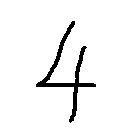

predicted number is 4 [121.00]


In [34]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Read input image
!wget -O 4.jpg  "https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A" 
img = cv2.imread("4.jpg")
cv2_imshow(img)

# Pre process
## グレースケール化、リサイズ、白黒判定、価範囲を-128～127
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))
img = (255 - img) - 128

# img = img.astype(np.uint8)
img = img.astype(np.int8)
input_tensor = img.reshape(1, img.shape[0], img.shape[1], 1)
input_tensor = tf.convert_to_tensor(input_tensor)

# Load model
interpreter = tf.lite.Interpreter(model_path="conv_mnist_quant.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# set input tensor
interpreter.set_tensor(input_details[0]['index'], input_tensor)

# Inference
interpreter.invoke()

scores = interpreter.get_tensor(output_details[0]['index'])
result = np.argmax(scores[0])

print("predicted number is {} [{:.2f}]".format(result, scores[0][result]))

## Convert tflite model into C code using xxd

In [9]:
!sudo apt install xxd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xxd
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 49.3 kB of archives.
After this operation, 200 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.4 [49.3 kB]
Fetched 49.3 kB in 1s (87.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package xxd.
(Reading database ... 146425 files and directories c

In [32]:
!xxd -i conv_mnist_quant.tflite > conv_mnist_quant.cpp
!xxd -i conv_mnist.tflite > conv_mnist.cpp
!ls -la

total 904
drwxr-xr-x 1 root root   4096 Feb 14 16:50 .
drwxr-xr-x 1 root root   4096 Feb 14 16:13 ..
-rw-r--r-- 1 root root   2971 Feb 14 16:58 4.jpg
drwxr-xr-x 1 root root   4096 Feb 10 14:40 .config
drwxr-xr-x 2 root root   4096 Feb 14 16:50 conv_mnist
-rw-r--r-- 1 root root 218360 Feb 14 16:59 conv_mnist.cpp
-rw-r--r-- 1 root root 135568 Feb 14 16:54 conv_mnist.h5
-rw-r--r-- 1 root root  73060 Feb 14 16:59 conv_mnist_quant.cpp
-rw-r--r-- 1 root root  11832 Feb 14 16:55 conv_mnist_quant.tflite
-rw-r--r-- 1 root root  35396 Feb 14 16:55 conv_mnist.tflite
-rw-r--r-- 1 root root 411142 Feb 14 16:50 conv_mnist.zip
drwxr-xr-x 4 root root   4096 Feb 14 16:14 logs
drwxr-xr-x 1 root root   4096 Feb 10 14:40 sample_data


In [33]:
!mkdir conv_mnist
!cp conv_mnist*.* conv_mnist/.
!zip conv_mnist.zip -r conv_mnist
from google.colab import files
files.download( "./conv_mnist.zip")

mkdir: cannot create directory ‘conv_mnist’: File exists
updating: conv_mnist/ (stored 0%)
updating: conv_mnist/conv_mnist_quant.cpp (deflated 81%)
updating: conv_mnist/conv_mnist.cpp (deflated 76%)
updating: conv_mnist/conv_mnist_quant.tflite (deflated 29%)
updating: conv_mnist/conv_mnist.h5 (deflated 29%)
updating: conv_mnist/conv_mnist.tflite (deflated 10%)
updating: conv_mnist/conv_mnist.zip (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>